In [ ]:
!pip install neuralforecast transformers gputil


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
# Access your dataset via '/content/drive/My Drive/filtered_data.csv'


Mounted at /content/drive


In [ ]:
import os
import torch
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler , StandardScaler , LabelEncoder , OneHotEncoder
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeLLM



/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:
# %%
data = pd.read_csv('/content/drive/My Drive/filtered_data.csv')


# %%
data[['LCLid','ToU','holiday']] = data[['LCLid','ToU','holiday']].astype('object')


# %%
df = data[['LCLid', 'day','energy_sum','temperature_avg','dewPoint','EnergyClass', 'Acorn_grouped','day_of_week', 'month_of_year','holiday']]

In [ ]:
# Rename columns to match NeuralForecast requirements
df = df.rename(columns={'LCLid': 'unique_id', 'day': 'ds', 'energy_sum': 'y'})

# Ensure 'ds' is a datetime object
df['ds'] = pd.to_datetime(df['ds'])

# Drop unnecessary columns if needed
df = df[['unique_id', 'ds', 'y']]

print(df.head())

  unique_id         ds      y
0       131 2012-07-01  6.281
1       131 2012-07-02  7.441
2       131 2012-07-03  8.279
3       131 2012-07-04  5.938
4       131 2012-07-05  6.082


In [ ]:
# Select unique IDs
sampled_ids = df['unique_id'].unique()[:1000]  # Adjust for more/less
df_small = df[df['unique_id'].isin(sampled_ids)].copy()

#print(f"Selected unique IDs: {sampled_ids}")
#print(f"Filtered dataset shape: {df_small.shape}")


In [ ]:
# Define prediction horizon and encoder input size
h = 14  # Forecast horizon (14 days)
input_size = 2 * 14  # 12 weeks = 84 days

# Split the data
Y_train_df = df[df['ds'] < (df['ds'].max() - pd.Timedelta(days=h + 14))]  # Training set
Y_val_df = df[(df['ds'] >= (df['ds'].max() - pd.Timedelta(days=h + 14))) &
              (df['ds'] < (df['ds'].max() - pd.Timedelta(days=h)))]  # Validation set
Y_test_df = df[df['ds'] >= (df['ds'].max() - pd.Timedelta(days=h))]  # Test set

print(f"Training Set: {Y_train_df.shape}")
print(f"Validation Set: {Y_val_df.shape}")
print(f"Test Set: {Y_test_df.shape}")

Training Set: (1487772, 3)
Validation Set: (36036, 3)
Test Set: (38610, 3)


In [ ]:
# Prompt for the LLM
prompt_prefix = (
    "The dataset contains daily energy consumption data. "
    "We aim to forecast the next 14 days using the last 168 days of data."
    "There is seasonal trend as colder month the energy consumption is higher and vice versa."
    "On weekend energy consumption is higher"
)

# Define the TimeLLM model
timellm = TimeLLM(
    h=14,
    input_size=168,  # Encoder input size (168 days)
    llm='openai-community/gpt2-small',  # LLM backend
    prompt_prefix=prompt_prefix,
    batch_size=1,
    start_padding_enabled=False,
    windows_batch_size=16,
    d_model = 32,
    d_llm= 768,
    d_ff= 128,
    max_steps=10000,
    val_check_steps=500,
    learning_rate=0.0001,
    optimizer=torch.optim.Adam,
    n_heads=8

)

# Initialize NeuralForecast with daily frequency
nf = NeuralForecast(
    models=[timellm],
    freq='D'  # Daily frequency
)

# Fit the model
nf.fit(df=Y_train_df, val_size=14)  # Use the last 14 days of training data for validation

INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Failed to load openai-community/gpt2-small. Loading the default model (openai-community/gpt2)...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | C

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10000` reached.


In [ ]:
forecasts = nf.predict(futr_df=Y_test_df)

/usr/local/lib/python3.11/dist-packages/neuralforecast/core.py:904: UserWarning: Dropped 75,000 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Merge on unique_id and ds to align actuals with predictions
aligned = Y_test_df.merge(forecasts, on=['unique_id', 'ds'], how='inner')

# Extract aligned actual and predicted values
y_true_aligned = aligned['y'].values  # Aligned actual values
y_pred_aligned = aligned['TimeLLM'].values  # Aligned predicted values

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# MAE
mae = mean_absolute_error(y_true_aligned, y_pred_aligned)

# RMSE
rmse = mean_squared_error(y_true_aligned, y_pred_aligned)

# MAPE
mape = np.mean(np.abs((y_true_aligned - y_pred_aligned) / y_true_aligned)) * 100

# SMAPE
smape = np.mean(2 * np.abs(y_true_aligned - y_pred_aligned) / (np.abs(y_true_aligned) + np.abs(y_pred_aligned))) * 100

# Print results
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")

MAE: 2.1360781374455358
RMSE: 13.633528447976946
MAPE: inf%
SMAPE: 22.89%


<ipython-input-13-e498feaa3817>:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true_aligned - y_pred_aligned) / y_true_aligned)) * 100


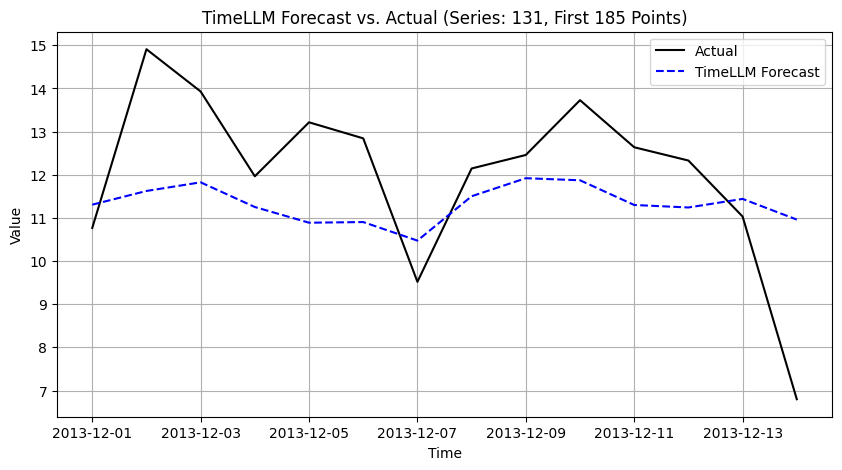

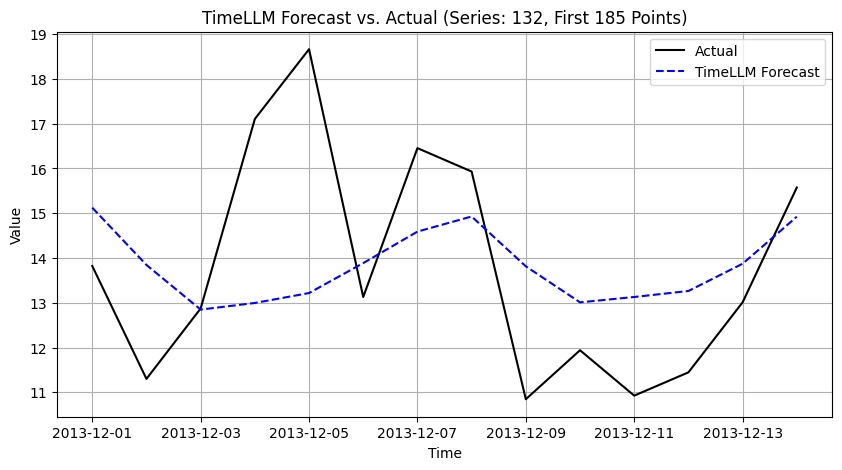

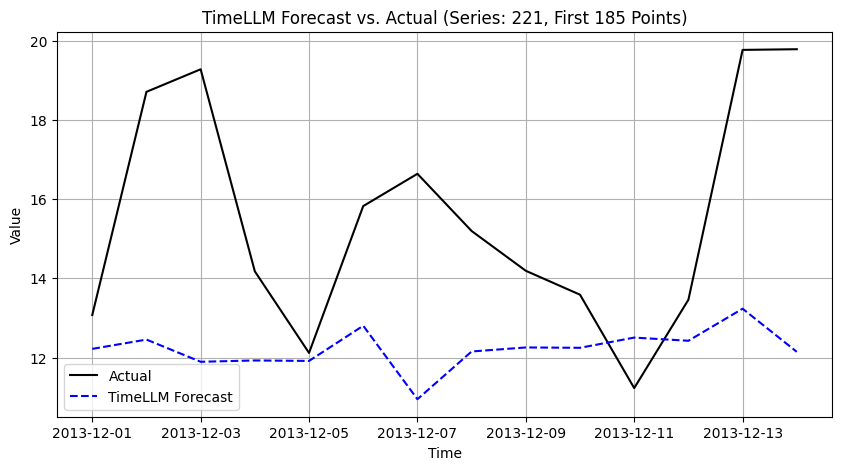

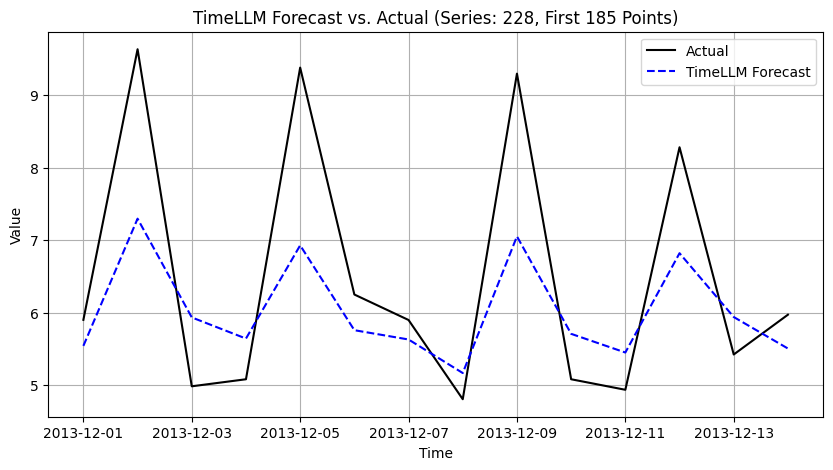

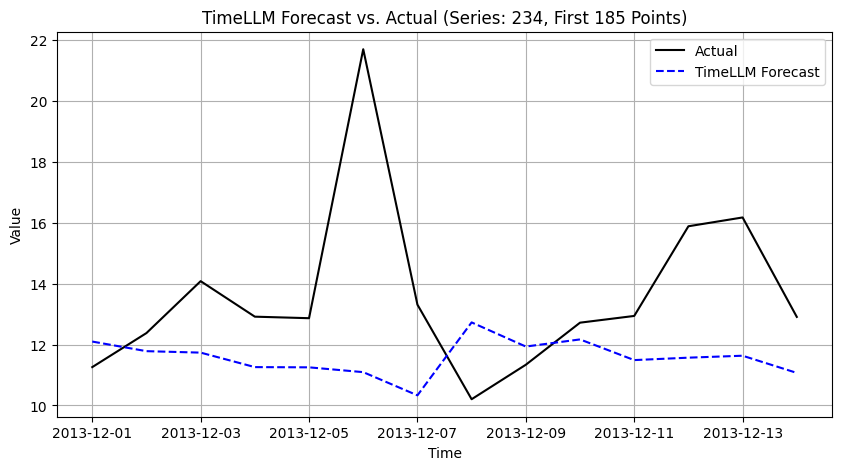

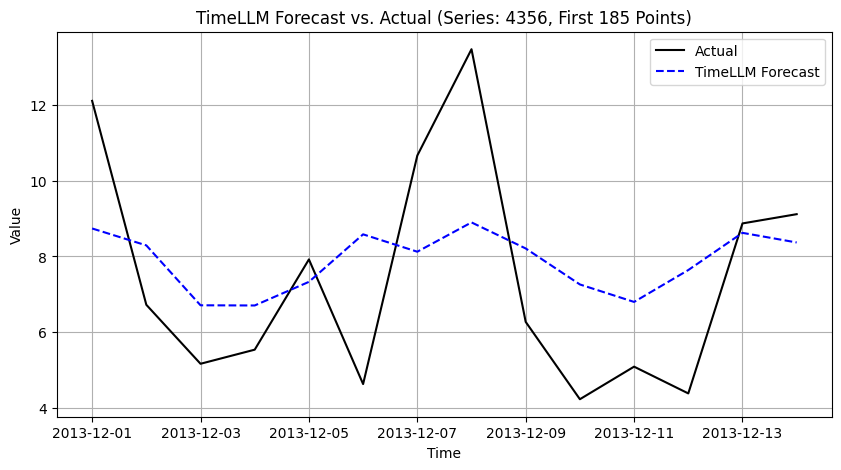

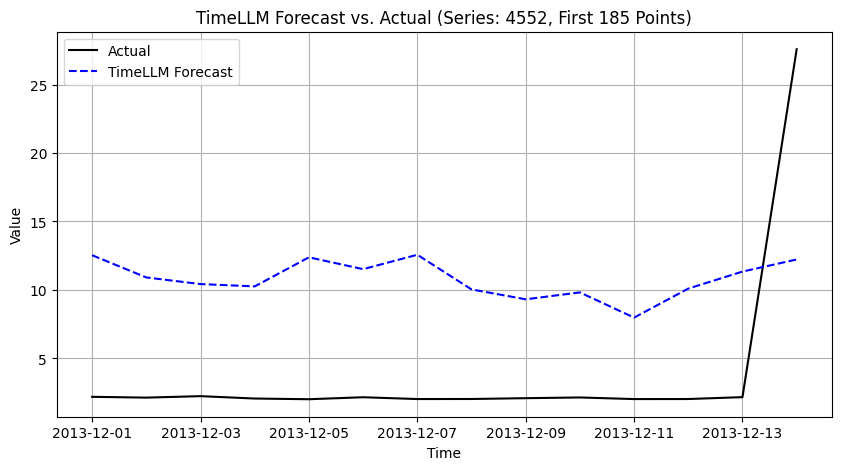

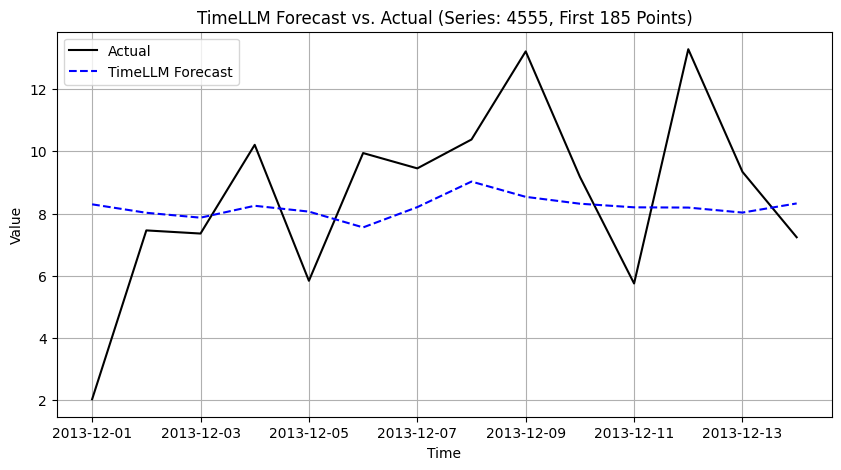

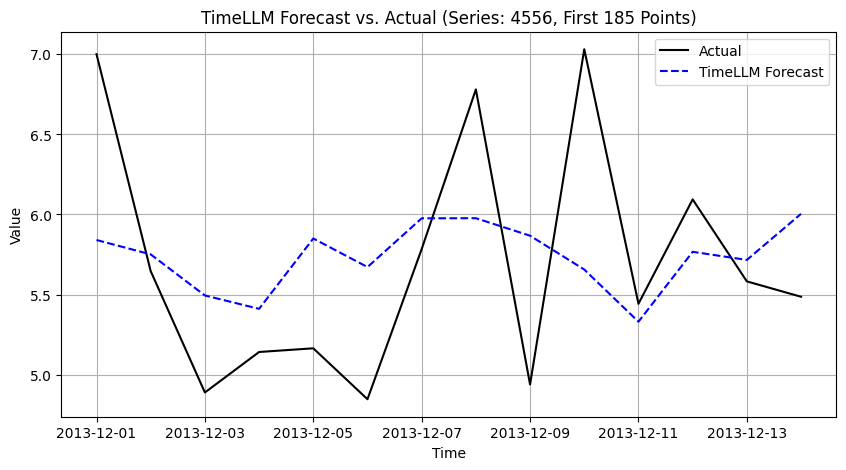

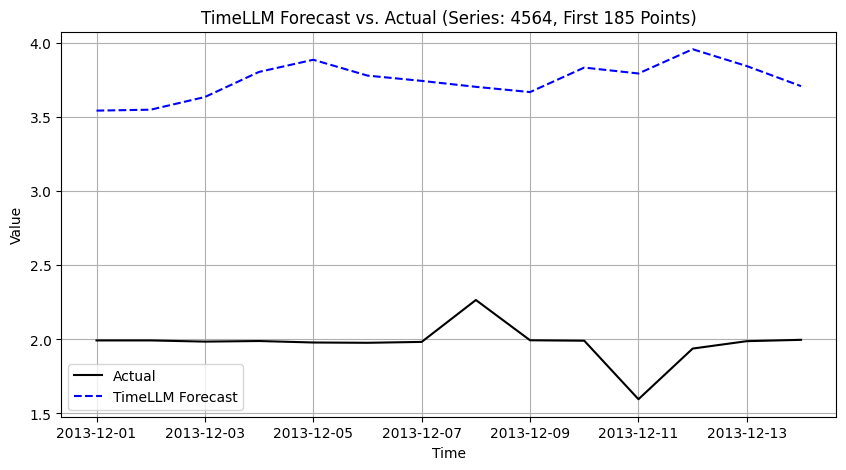

In [ ]:
# Get unique series IDs
unique_ids = aligned['unique_id'].unique()

# Plot each series
for unique_id in unique_ids[:10]:  # Limit to the first 10 series for simplicity
    series = aligned[aligned['unique_id'] == unique_id].iloc[:185]  # First 185 points for this ID

    plt.figure(figsize=(10, 5))
    plt.plot(series['ds'], series['y'], label="Actual", color='black')
    plt.plot(series['ds'], series['TimeLLM'], label="TimeLLM Forecast", color='blue', linestyle='dashed')

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"TimeLLM Forecast vs. Actual (Series: {unique_id}, First 185 Points)")
    plt.legend()
    plt.grid()
    plt.show()
